# 0.2.6 Regla delta generalizada y algoritmos con supermemoria

Notas:
- 

In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [118]:
import sys
sys.path.append("../../../../") 

import utils.paths as path
from utils.paths2 import direcciones

## 0.2.6.1 Definición del problema de estimación de parámetros y función de pérdida

Se desean encontra los parámetros w0 y w1 del siguiente modelo de regresión entre las variables x y y:

$$ y_{i} = w_{i}x_{i} + w_{0} + e_{i} $$

a partir de un conjunto de observaciones ${d_{i}, x_{i}}$, donde $d_{i}$ es el valor real (observado), $y_{i}$ es su aproximación usando el modelo de regresión descrito, y $e_{i}$ es el error aleatorio.

- Error instantáneo:

$$ e_{i} = d_{i} - y_{i} $$

- Sumatoria del error cuadrático instantáneo:

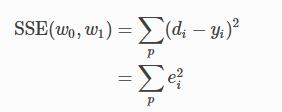

In [119]:
#
# Dataset
#
x_sample = [
    0.1087,0.2698,0.3765,0.2146,0.9155,0.0246,
    0.0221,0.8632,0.6460,0.2092,0.8567,0.1591,
    0.9647,0.6231,0.7460,0.3654,0.3065,0.6886,
    0.4966,0.2008,0.2618,0.7607,0.1563,0.4424,
    0.7731,
]

y_sample = [
    0.9519,1.1237,1.2360,1.0526,2.0743,0.7906,
    0.7603,2.0533,1.6887,1.0563,2.0991,0.8953,
    2.1917,1.6266,1.8508,1.2828,1.2283,1.8722,
    1.4657,1.0418,1.1097,1.7826,0.9711,1.4267,
    1.8248,
]

## 0.2.6.2 Función de pérdida

In [120]:
#
# Sumatoria del error cuadrático o pérdida cuadrática
#
def sse(w0, w1):
    y_forecasts = [w0 + w1 * x_value for x_value in x_sample]
    errors = [y_true - y_forecast for y_true, y_forecast in zip(y_sample, y_forecasts)]
    squared_errors = [error ** 2 for error in errors]
    return sum(squared_errors)

## 0.2.6.3 Método del gradiente

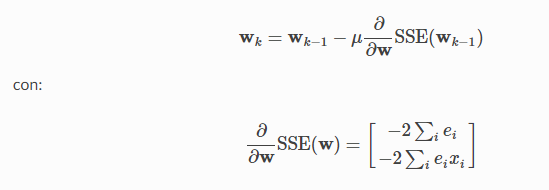

## 0.2.6.4 Derivadas

In [121]:
#
# Esta es el mismo computo que el empleado en el
# método batch.
#
def gradient(w0, w1):

    y_forecasts = [w0 + w1 * x_value for x_value in x_sample]

    errors = [y_true - y_forecast for y_true, y_forecast in zip(y_sample, y_forecasts)]

    gradient_w0 = -2 * sum(errors)
    gradient_w1 = -2 * sum([error * x_value for error, x_value in zip(errors, x_sample)])

    return gradient_w0, gradient_w1

## 0.2.6.5 Ecuación de mejora

In [122]:
def improve(w0, w1, mu):

    gradient_w0, gradient_w1 = gradient(w0, w1)

    w0 = w0 - mu * gradient_w0
    w1 = w1 - mu * gradient_w1

    return w0, w1

## 0.2.6.6 Proceso iterativo 

In [123]:
def plot_contour():

    W0 = np.linspace(-0.4, 1.5, 100)
    W1 = np.linspace(1.2, 3.0, 100)
    W0, W1 = np.meshgrid(W0, W1)
    F = sse(W0, W1)

    levels = [0, 0.2, 0.5, 0.75, 1, 2, 3, 5, 10, 20, 30, 40, 50, 60]

    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal", "box")
    ax.contourf(W0, W1, F, cmap=cm.Greys, levels=levels, alpha=0.6)
    ax.contour(W0, W1, F, colors="gray", levels=levels)
    plt.plot(
        [0.731],
        [1.498],
        "o",
        color="black",
        fillstyle="none",
        markersize=11,
        markeredgewidth=2,
    )
    plt.plot([0.731], [1.498], ".", color="black")
    ax.set_xlabel("w0")
    ax.set_ylabel("w1")
    ax.grid()

 w0 = 0.6786
 w1 = 1.6341
SSE = 0.0924


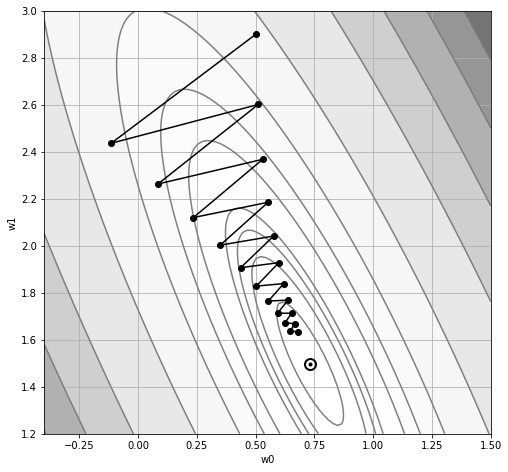

In [124]:
# Punto de inicio
w0 = 0.5
w1 = 2.9

history_gd = {
    "w0": [w0],
    "w1": [w1],
    "sse": [sse(w0, w1)],
}

mu = 0.03

for epoch in range(20):

    w0, w1 = improve(w0, w1, mu)

    history_gd["w0"].append(w0)
    history_gd["w1"].append(w1)
    history_gd["sse"].append(sse(w0, w1))

print(" w0 = {:6.4f}\n w1 = {:6.4f}\nSSE = {:6.4f}".format(w0, w1, sse(w0, w1)))

plot_contour()
plt.plot(history_gd["w0"], history_gd["w1"], marker="o", color="black")
plt.show()

## 0.2.6.7 Momentum

Para evitar el zigzag, se desea usar la dirección del gradiente actual ponderada por la dirección previa. Esta metodología se conoce como regla delta (en la jerga de redes neuronales artificiales) o gradiente con memoria (en investigación de operaciones).

Específicamente, el proceso de optimización se basa en la siguiente ecuación recursiva (ya estudiada):

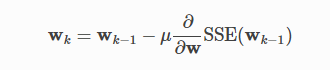

la cual que puede ser reescrita como:

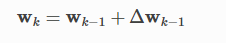

con:

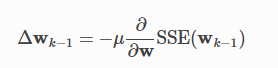

La dirección tomada en la iteración anterior será Δwk−2. Ahora, solo es necesario agregar este término a la ecuación anterior, ponderado por un parámetro β conocido comúnmente como momentum:

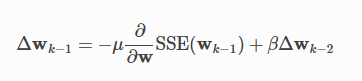

## 0.2.6.8 Proceso iterativo 

In [125]:
def improve(w0, w1, mu, beta):

    # Corrección en la iteración anterior.
    global previous_delta_w0
    global previous_delta_w1

    # Computó del gradiente para los parámetros actuales
    gradient_w0, gradient_w1 = gradient(w0, w1)

    # Corrección de los parámetros
    delta_w0 = -mu * gradient_w0 + beta * previous_delta_w0
    delta_w1 = -mu * gradient_w1 + beta * previous_delta_w1

    # Almacenamiento de la corrección para la siguiente iteración
    previous_delta_w0 = delta_w0
    previous_delta_w1 = delta_w1

    w0 = w0 + delta_w0
    w1 = w1 + delta_w1

    return w0, w1

El proceso de iterativo de optimización es el siguiente:

 w0 = 0.7053
 w1 = 1.5258
SSE = 0.0571


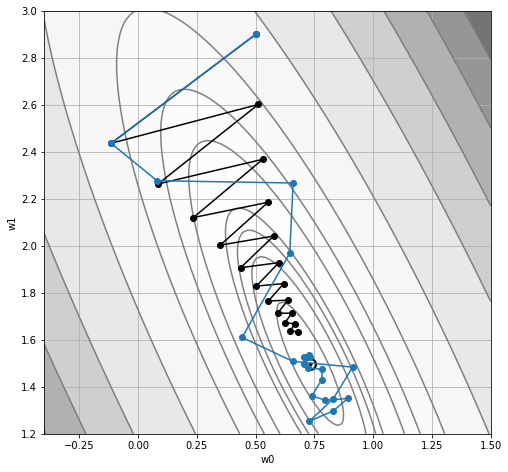

In [126]:
# Punto de inicio
w0 = 0.5
w1 = 2.9

history_dr = {
    "w0": [w0],
    "w1": [w1],
    "sse": [sse(w0, w1)],
}

previous_delta_w0 = 0
previous_delta_w1 = 0

for epoch in range(20):

    w0, w1 = improve(w0, w1, mu=0.03, beta=0.7)

    history_dr["w0"].append(w0)
    history_dr["w1"].append(w1)
    history_dr["sse"].append(sse(w0, w1))

print(" w0 = {:6.4f}\n w1 = {:6.4f}\nSSE = {:6.4f}".format(w0, w1, sse(w0, w1)))

plot_contour()
plt.plot(history_gd["w0"], history_gd["w1"], marker="o", color="black")
plt.plot(history_dr["w0"], history_dr["w1"], marker="o", color="tab:blue")
plt.show()

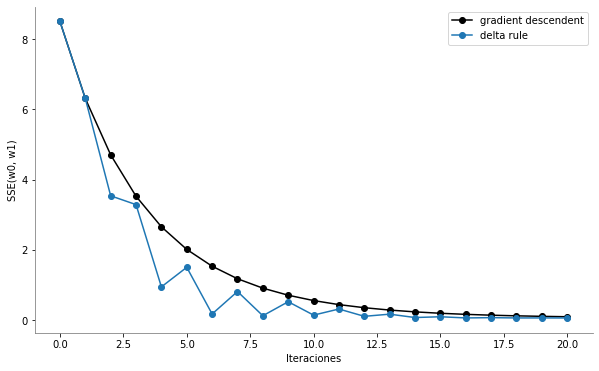

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(history_gd["sse"], "o-k", label="gradient descendent")
plt.plot(history_dr["sse"], "o-", color="tab:blue", label="delta rule")
plt.xlabel("Iteraciones")
plt.ylabel("SSE(w0, w1)")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.show()

In [128]:
def improve(w0, w1, mu):

    gradient_w0, gradient_w1 = gradient(w0, w1)

    w0 = w0 - mu * gradient_w0
    w1 = w1 - mu * gradient_w1

    return w0, w1

In [129]:
def improve2(w0, w1, mu, beta):

    # Corrección en la iteración anterior.
    global previous_delta_w0
    global previous_delta_w1

    # Computó del gradiente para los parámetros actuales
    gradient_w0, gradient_w1 = gradient(w0, w1)

    # Corrección de los parámetros
    delta_w0 = -mu * gradient_w0 + beta * previous_delta_w0
    delta_w1 = -mu * gradient_w1 + beta * previous_delta_w1

    # Almacenamiento de la corrección para la siguiente iteración
    previous_delta_w0 = delta_w0
    previous_delta_w1 = delta_w1

    w0 = w0 + delta_w0
    w1 = w1 + delta_w1

    return w0, w1

In [130]:
def epocas(w0g, w1g, w0, w1, epocas, learning_rate, factor_beta):
    
    history_gd = {"w0": [w0], "w1": [w1], "sse": [sse(w0, w1)]}
    history_dr = {"w0": [w0],"w1": [w1],"sse": [sse(w0, w1)]}
    
    previous_delta_w0 = 0
    previous_delta_w1 = 0
    
    for epoch in range(epocas):
        
        w0g, w1g = improve(w0g, w1g, learning_rate)

        history_gd["w0"].append(w0g)
        history_gd["w1"].append(w1g)
        history_gd["sse"].append(sse(w0g, w1g))
        
        
        w0, w1 = improve2(w0, w1, learning_rate, factor_beta)
            
        history_dr["w0"].append(w0)
        history_dr["w1"].append(w1)
        history_dr["sse"].append(sse(w0, w1))
    
    #
    # Ultimo resultado obtenido
    #
    # print(" w0 = {:6.4f}\n w1 = {:6.4f}\nSSE = {:6.4f}".format(w0, w1, sse(w0, w1)))
    
    return history_gd, history_dr

In [131]:
history_gd, history_dr = epocas(0.5, 2.9, 0.5, 2.9, 15, 0.02, 0.6)

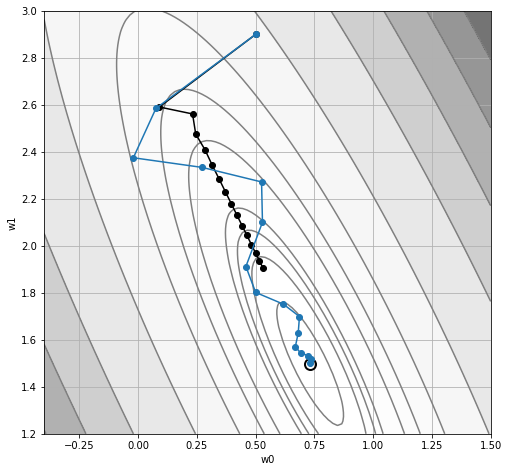

In [132]:
plot_contour()
plt.plot(history_gd["w0"], history_gd["w1"], marker="o", color="black")
plt.plot(history_dr["w0"], history_dr["w1"], marker="o", color="tab:blue")
plt.show()

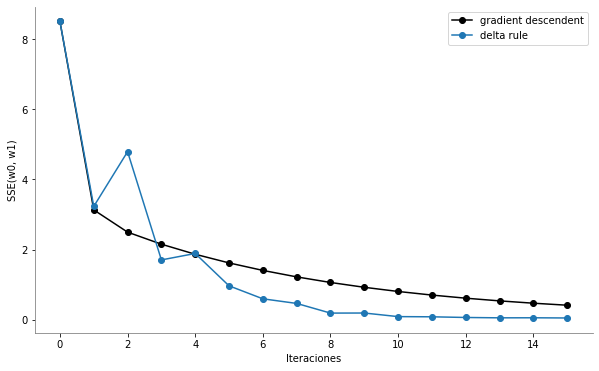

In [133]:
plt.figure(figsize=(10, 6))
plt.plot(history_gd["sse"], "o-k", label="gradient descendent")
plt.plot(history_dr["sse"], "o-", color="tab:blue", label="delta rule")
plt.xlabel("Iteraciones")
plt.ylabel("SSE(w0, w1)")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.show()

## 0.2.6.9 Algoritmos con supermemoria

Son algoritmos de estructura similar a la regla delta, pero consideran P valores de Δw hacia atrás.

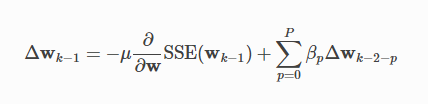

In [134]:
print('ok_')

ok_
